In [1]:
# Data processing tools: pandas and numpy
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC

# Regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR

# Visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve


from sklearn.pipeline import make_pipeline
# Others
import time
import warnings
warnings.filterwarnings('ignore')

# Parameters of the experiments

In [2]:
# Dataset parameters
regression = False
dataset_number = 1

# Noise mode
# 0 - no noise
# 1 - AWGN noise
# 2 - replacements
noise_mode = 1
SNR = 10

# Dropping mode
# 0 - no dropping
# 1 - MCAR
# 2 - MAR
# 3 - NMAR
dropping_mode = 1
dropping_probability = 0.3

# Imputation mode
# 0 - dropping
# 1 - filling with 0
# 2 - filling with mean
# 3 - filling with median
# 4 - filling by MICE
# 5 - filling by kNN
imputation_mode = 3

# Reproducibility parameters
random_state = 0
test_size = 0.25

# Visualization parameters
get_feature_importance = True
get_best_models = True

# Read dataset

In [3]:
directory = "Datasets/"

datasets_regression = [
    "productivity_prediction(R)",
    "bias_correction_temp_forecast(R)",
#     "air_quality(R)",
]

datasets_classification = [
    "census_income(C)",
    "mushroom(C)",
    "ozone_level_detection(C)",
    "polish_companies_bankruptcy(C)",
#     "diabetes_130-US(C)",
]

# if regression:
#     datasets = datasets_regression
# else:
#     datasets = datasets_classification
    
# dataset = datasets[dataset_number]

df = pd.read_csv('/content/mushroom(C)_withoutNANs.csv')
df.head()

,Unnamed: 0,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,e,x,s,y,t,a,f,c,b,...,s,w,w,p,w,o,p,n,n,g
1,1,e,b,s,w,t,l,f,c,b,...,s,w,w,p,w,o,p,n,n,m
2,2,p,x,y,w,t,p,f,c,n,...,s,w,w,p,w,o,p,k,s,u
3,3,e,x,s,g,f,n,f,w,b,...,s,w,w,p,w,o,e,n,a,g
4,4,e,x,y,y,t,a,f,c,b,...,s,w,w,p,w,o,p,k,n,g


In [4]:
# df.shape

# Add noise

In [5]:
SNR_times = 10 ** (SNR / 10.)

np.random.seed(random_state)

noised = df.copy()

if noise_mode == 1:
    continuous_features =  list(df.columns[df.dtypes != "object"])
    signal_powers = (abs(df[continuous_features]) ** 2).mean()

    for feature in continuous_features:
        signal_power = signal_powers[feature]
        noise_power = signal_power / SNR_times
        noise = np.random.normal(0,1,df.shape[0])
        noise *= np.sqrt(noise_power)
        noised[feature] += noise
        
df = noised

# Drop values

In [6]:
if dropping_mode == 1:
    for i in range(df.shape[1]):
        if df.columns[i] != 'Target':
            for j in range(df.shape[0]):
                if np.random.uniform() < dropping_probability:
                    df.iloc[j, i] = None

# Impute data

In [7]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5643 entries, 0 to 5642
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                3913 non-null   float64
 1   target                    3915 non-null   object 
 2   cap-shape                 3915 non-null   object 
 3   cap-surface               3975 non-null   object 
 4   cap-color                 3966 non-null   object 
 5   bruises                   3933 non-null   object 
 6   odor                      3937 non-null   object 
 7   gill-attachment           3973 non-null   object 
 8   gill-spacing              3925 non-null   object 
 9   gill-size                 3944 non-null   object 
 10  gill-color                3978 non-null   object 
 11  stalk-shape               3928 non-null   object 
 12  stalk-root                3881 non-null   object 
 13  stalk-surface-above-ring  4022 non-null   object 
 14  stalk-su

In [ ]:
df

,Unnamed: 0,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1817.201830,e,x,s,y,t,a,None,c,None,...,s,w,w,p,w,o,p,n,n,g
1,413.213625,e,b,s,w,t,l,None,c,b,...,s,w,w,p,w,o,p,n,n,m
2,1010.226576,p,None,None,w,None,None,None,c,n,...,None,None,None,p,w,None,None,k,None,None
3,2311.409516,e,x,None,None,f,None,f,w,None,...,s,w,w,p,w,o,e,n,None,g
4,1927.826017,e,x,y,y,t,None,None,c,None,...,None,w,w,None,w,o,p,None,None,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638,NaN,e,b,y,None,None,n,None,None,b,...,y,n,n,p,w,t,None,w,None,p
5639,5903.464492,e,x,y,n,f,None,f,None,b,...,None,n,n,p,w,t,p,w,None,None
5640,5822.200478,None,None,y,g,t,None,None,c,b,...,s,w,w,p,None,t,p,w,y,p
5641,4946.567060,p,x,y,c,f,m,f,None,b,...,None,c,c,None,w,None,n,w,c,d


In [8]:
if imputation_mode == 0:
    filled = df.dropna()
elif imputation_mode == 1:
    filled = df.fillna(0)
elif imputation_mode == 2:
    filled = df.copy()

    categorical_features = list(df.columns[df.dtypes == "object"])
    continuous_features =  list(df.columns[df.dtypes != "object"])

    for feature in categorical_features:
        filled[feature].fillna(filled[feature].value_counts().index[0], inplace=True)
    for feature in continuous_features:
        filled[feature].fillna(filled[feature].mean(), inplace=True)
elif imputation_mode == 3:
    filled = df.copy()

    categorical_features = list(df.columns[df.dtypes == "object"])
    continuous_features =  list(df.columns[df.dtypes != "object"])

    for feature in categorical_features:
        filled[feature].fillna(filled[feature].value_counts().index[0], inplace=True)
    for feature in continuous_features:
        filled[feature].fillna(filled[feature].median(), inplace=True)
        
df = filled

In [9]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5643 entries, 0 to 5642
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                5643 non-null   float64
 1   target                    5643 non-null   object 
 2   cap-shape                 5643 non-null   object 
 3   cap-surface               5643 non-null   object 
 4   cap-color                 5643 non-null   object 
 5   bruises                   5643 non-null   object 
 6   odor                      5643 non-null   object 
 7   gill-attachment           5643 non-null   object 
 8   gill-spacing              5643 non-null   object 
 9   gill-size                 5643 non-null   object 
 10  gill-color                5643 non-null   object 
 11  stalk-shape               5643 non-null   object 
 12  stalk-root                5643 non-null   object 
 13  stalk-surface-above-ring  5643 non-null   object 
 14  stalk-su

# Train-test split and preprocessing

In [10]:
if regression:
    y = df['Target']
else:
    encoder = preprocessing.LabelEncoder()
    y = encoder.fit_transform(df['target'])

X = pd.get_dummies(df.drop('target', axis = 1), drop_first = False)

# Train-test split
# make only train-test
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
#                                                             test_size = test_size, random_state = random_state)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
#                                                   test_size = test_size, random_state = random_state)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

# X = StandardScaler().fit(X_train)

In [60]:
# Models used
if regression:
    models = [
        DecisionTreeRegressor(random_state = random_state),
        SVR(),
        RandomForestRegressor(random_state = random_state, n_jobs = -1),
        ExtraTreesRegressor(random_state = random_state, n_jobs = -1),
    ]
else:
    models = [
        DecisionTreeClassifier(random_state = random_state),
        LinearSVC(random_state = random_state),
        RandomForestClassifier(random_state = random_state, n_jobs = -1),
        ExtraTreesClassifier(random_state = random_state, n_jobs = -1),
    ]

# Parameters grid
grid_search_parameters = {
    # make pipeline, grid search
    'n_estimators': list(range(10, 100, 30)),
    'max_depth': [3, 5],
    'C': np.logspace(-3, 3, 7),
    'kernel': ['poly', 'rbf'], 
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
          }
print(grid_search_parameters['n_estimators'])

[10, 40, 70]


DecisionTreeClassifier  best with  {'decisiontreeclassifier__max_depth': 5}
LinearSVC  best with  {'linearsvc__C': 0.001}
RandomForestClassifier  best with  {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 10}

 The most important features:
spore-print-color_h           0.120044
stalk-surface-above-ring_k    0.098558
odor_f                        0.094114
stalk-surface-below-ring_k    0.076312
Unnamed: 0                    0.059455
stalk-shape_t                 0.055627
odor_n                        0.054305
ring-type_l                   0.043371
stalk-shape_e                 0.041089
gill-size_n                   0.028716
dtype: float64


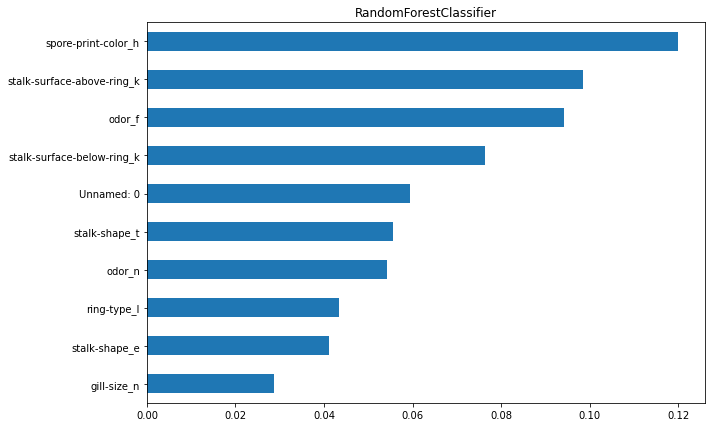

ExtraTreesClassifier  best with  {'extratreesclassifier__max_depth': 5, 'extratreesclassifier__n_estimators': 70}


In [78]:
test_scores = []

def getkeys(dict): 
    return [*dict]

for model in models:
    # Intersection of keys for GridSearchCV
    intersection_keys = model.get_params().keys() & grid_search_parameters.keys()
    parameters_grid = {}
    pipeline_params_grid = {}

    for key in intersection_keys:
        parameters_grid[key] = grid_search_parameters[key]
    
    if regression:
      # Option 1
        # gcv = GridSearchCV(model, parameters_grid, scoring = 'neg_mean_absolute_percentage_error', cv = 3, n_jobs = -1, refit=True)
        # pln = make_pipeline(StandardScaler(), gcv).fit(X_train, y_train)
      
      # Option 2  
        pln = make_pipeline(StandardScaler(), model)
        for i in range(len(parameters_grid)):
            pipeline_params_grid[str(pln.steps[1][0]) + '__' + 
                                     str(getkeys(parameters_grid)[i])] = parameters_grid[str(getkeys(parameters_grid)[i])]
        gcv = GridSearchCV(pln, parameters_grid, scoring = 'neg_mean_absolute_percentage_error', cv = 3,
                           n_jobs = -1, refit = True)
    else:
      # Option 1 
        # gcv = GridSearchCV(model, parameters_grid, scoring = 'f1_micro', cv = 3, n_jobs = -1, refit = True)
        # pln = make_pipeline(StandardScaler(), gcv).fit(X_train, y_train)
      
      # Option 2 
        pln = make_pipeline(StandardScaler(), model)
        # print(str(pln.steps[1][0]))
        for i in range(len(parameters_grid)):
            # print(str(pln.steps[1][0]) + '__' + str(getkeys(parameters_grid)[i]))

            # Parameters of pipelines can be set only using ‘__’ separated parameter names, that's why 
            # new pipeline_params_grid set was implemented
            pipeline_params_grid[str(pln.steps[1][0]) + '__' + 
                                     str(getkeys(parameters_grid)[i])] = parameters_grid[str(getkeys(parameters_grid)[i])]              
        # print(pipeline_params_grid)
        # print('\n')
        gcv = GridSearchCV(pln, pipeline_params_grid, scoring = 'f1_micro', cv = 3, n_jobs = -1, refit = True)
    
    gcv.fit(X_train, y_train)
    if get_best_models:
        print(model.__class__.__name__, ' best with ', gcv.best_params_)
        
    # Feature importances
    if get_feature_importance and model.__class__.__name__ == 'RandomForestClassifier':
        fimp = pd.Series(gcv.best_estimator_[1].feature_importances_, index = X_train.columns)
        print('\n The most important features:')
        print(fimp.nlargest(10))
        fimp.nlargest(10).sort_values(ascending = True).plot.barh(figsize = (10, 7),
                                                                  title = model.__class__.__name__)
        plt.show()

    # Calculate score
    if regression:
        test_scores.append(np.round(mape(y_test, gcv.best_estimator_.predict(X_test)), 2))
    else:
        test_scores.append(np.round(f1_score(y_test, gcv.best_estimator_.predict(X_test)), 2))

In [79]:
pd.DataFrame({'Models': [model.__class__.__name__ for model in models],
            'Test score': test_scores
})

,Models,Test score
0,DecisionTreeClassifier,0.75
1,LinearSVC,0.78
2,RandomForestClassifier,0.71
3,ExtraTreesClassifier,0.71
